In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista
import ufl
import time
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import fem, mesh, plot, nls, log, io
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import dolfinx
print(dolfinx.__version__)

0.6.0


In [25]:
xlim = 4
ylim = 2
zlim = 2
nx = 40
ny = 15
nz = 15

vertex = [xlim, ylim, zlim]
domain = mesh.create_box(MPI.COMM_WORLD, 
                         [[0.0, 0.0, 0.0], vertex], 
                         [nx, ny, nz], 
                         mesh.CellType.tetrahedron) 

In [26]:
top, cel, geom = plot.create_vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(top, cel, geom)
pyvista.set_jupyter_backend('panel')
pyvista.start_xvfb()
plotter = pyvista.Plotter()
    
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
plotter.close()

  pyvista.set_jupyter_backend('panel')



VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, sizing_mode='stretch_width')

In [27]:
sigma_space = fem.TensorFunctionSpace(domain, ('Lagrange', 1))
force_space = fem.FunctionSpace(domain, ("Lagrange", 1))

In [28]:
V = fem.VectorFunctionSpace(domain, ('Lagrange', 2))
atol = 1E-10

def left(x): # D0
    return np.isclose(x[0], 0, atol=atol)
    # return np.isclose(x[0], vertex[0])

def right(x): # D1
    return np.isclose(x[0], xlim, atol=atol)
    # return np.isclose(x[0], 0)

def front(x): # N
    return np.isclose(x[1], 0, atol=atol)
    # return np.isclose(x[2], 0)
    
def back(x):
    return np.isclose(x[1], ylim, atol=atol)
    # return np.isclose(x[2], vertex[2])

def bottom(x):
    return np.isclose(x[2], 0, atol=atol)
    # return np.isclose(x[1], vertex[1])

def top(x):
    return np.isclose(x[2], zlim, atol=atol)
    # return np.isclose(x[1], 0)

fdim = domain.topology.dim -1

left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)
front_facets = mesh.locate_entities_boundary(domain, fdim, front)
back_facets = mesh.locate_entities_boundary(domain, fdim, back)
bottom_facets = mesh.locate_entities_boundary(domain, fdim, bottom)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)

In [29]:
right_facets

array([    3,     6,    13,    23,    29,    37,    42,    45,    78,
          92,    98,   100,   103,   121,   123,   126,   196,   201,
         204,   225,   241,   243,   246,   268,   270,   273,   310,
         313,   374,   377,   397,   433,   461,   463,   466,   470,
         473,   503,   505,   508,   555,   558,   639,   642,   678,
         705,   708,   741,   768,   771,   788,   790,   793,   837,
         839,   842,   901,   904,   940,   943,  1016,  1019,  1081,
        1108,  1111,  1160,  1187,  1190,  1219,  1221,  1224,  1250,
        1253,  1295,  1297,  1300,  1326,  1329,  1378,  1381,  1516,
        1519,  1609,  1636,  1639,  1667,  1670,  1715,  1742,  1745,
        1796,  1798,  1801,  1827,  1830,  1888,  1890,  1893,  1919,
        1922,  1983,  1986,  2076,  2079,  2164,  2167,  2257,  2260,
        2292,  2319,  2322,  2417,  2444,  2447,  2522,  2524,  2527,
        2553,  2556,  2584,  2587,  2641,  2643,  2646,  2672,  2675,
        2758,  2761,

In [30]:
marked_facets = np.hstack([left_facets, right_facets, front_facets, back_facets, bottom_facets, top_facets])
marked_values = np.hstack([np.full_like(left_facets, 1), np.full_like(right_facets, 2),
                            np.full_like(front_facets, 3), np.full_like(back_facets, 4),
                              np.full_like(bottom_facets, 5), np.full_like(top_facets, 6)])
sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, fdim, marked_facets[sorted_facets], marked_values[sorted_facets])

In [31]:
alpha = 1
delta_max = 4

In [32]:
# Dirichlet boundary condition
u_d0 = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))
u_d1 = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))
T = fem.Constant(domain, PETSc.ScalarType((0, 0, 0)))

In [33]:
left_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(1))
right_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(2))
front_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(3))
back_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(4))
bottom_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(5))
top_dofs = fem.locate_dofs_topological(V, facet_tag.dim, facet_tag.find(6))

bcs = [fem.dirichletbc(u_d0, left_dofs, V), fem.dirichletbc(u_d1, right_dofs, V)]

In [34]:
eta = ufl.TestFunction(V)   # variación admisible (test function)
u = fem.Function(V)         # desplazamiento
u.name = "Desplazamiento"

In [35]:
# Spatial dimension
d = len(u)

# Identity tensor
I = ufl.variable(ufl.Identity(d))

# Deformation gradient
F = ufl.variable(I + ufl.grad(u)) 

# Right Cauchy-Green tensor
C = ufl.variable(F.T * F)

# Invariants of deformation tensors
I1 = ufl.variable(ufl.tr(C)) # = tr(F^T F)
I2 = ufl.variable(0.5*(ufl.tr(C)*ufl.tr(C) - ufl.tr(C*C))) 
J  = ufl.variable(ufl.det(F))

In [36]:
# Mooney-Rivlin parameters
c10 = 0.8
c01 = 0.5
D1 = 0.34

# Stored strain energy density (Birzle et al. model)
psi = c10 * (J**(-2/3)*I1 - 3) + c01 * (J**(-4/3)*I2) + (1/D1)*(J-1)**2

# Stress
# Hyper-elasticity
P = ufl.diff(psi, F)

sigma = ufl.variable(J**(-1)*P*F.T)

In [37]:
metadata = {"quadrature_degree": 3}

ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tag, metadata=metadata)
dx = ufl.Measure("dx", domain=domain, metadata=metadata)

F = ufl.inner(P, ufl.grad(eta))*dx
F += -ufl.inner(T, eta)*ds(3) -ufl.inner(T, eta)*ds(4)
F += -ufl.inner(T, eta)*ds(5) -ufl.inner(T, eta)*ds(6)

In [38]:
problem = fem.petsc.NonlinearProblem(F, u, bcs)

In [39]:
solver = nls.petsc.NewtonSolver(domain.comm, problem)

# Set Newton solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.convergence_criterion = "incremental"

In [40]:
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "superlu"
ksp.setFromOptions()

In [41]:
pyvista.start_xvfb()
plotter = pyvista.Plotter()
plotter.open_gif("alv_deformation.gif", fps=5)

topology, cells, geometry = plot.create_vtk_mesh(u.function_space)
function_grid = pyvista.UnstructuredGrid(topology, cells, geometry)

values = np.zeros((geometry.shape[0], 3))
values[:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
function_grid["u"] = values
function_grid.set_active_vectors("u")

# Warp mesh by deformation
warped = function_grid.warp_by_vector("u", factor=1)
warped.set_active_vectors("u")

# Add mesh to plotter and visualize
actor = plotter.add_mesh(warped, show_edges=True, lighting=False, clim=[0, 10])

# Compute magnitude of displacement to visualize in GIF
Vs = fem.FunctionSpace(domain, ("Lagrange", 2))
magnitude = fem.Function(Vs)
us = fem.Expression(ufl.sqrt(sum([u[i]**2 for i in range(len(u))])), Vs.element.interpolation_points())
magnitude.interpolate(us)
warped["mag"] = magnitude.x.array


In [42]:
xdmf = io.XDMFFile(domain.comm, "u.xdmf", "w")
xdmf.write_mesh(domain)

J_xdmf = io.XDMFFile(domain.comm, "J.xdmf", "w")
J_xdmf.write_mesh(domain)

lambda1_xdmf = io.XDMFFile(domain.comm, "lambda1.xdmf", "w")
lambda1_xdmf.write_mesh(domain)

lambda2_xdmf = io.XDMFFile(domain.comm, "lambda2.xdmf", "w")
lambda2_xdmf.write_mesh(domain)

lambda3_xdmf = io.XDMFFile(domain.comm, "lambda3.xdmf", "w")
lambda3_xdmf.write_mesh(domain)

# Define solution variable, and interpolate initial solution for visualization in Paraview
# uh = fem.Function(V)
# uh.name = "uh"
# uh.interpolate(initial_condiion)
# xdmf.write_function(uh, t)

In [43]:
sigma_xdmf = io.XDMFFile(domain.comm, "sigma.xdmf", "w")
sigma_xdmf.write_mesh(domain)

In [44]:
sigmao = dolfinx.fem.Function(dolfinx.fem.TensorFunctionSpace(domain, ('Lagrange',1)), name="sigma")
sigmao.name = 'sigma'

Jo = dolfinx.fem.Function(dolfinx.fem.FunctionSpace(domain, ('Lagrange',1)), name="J")
Jo.name = 'J'

lambda_1o = dolfinx.fem.Function(dolfinx.fem.FunctionSpace(domain, ('Lagrange',1)), name="lambda_1")
lambda_1o.name = 'lambda_1'

lambda_2o = dolfinx.fem.Function(dolfinx.fem.FunctionSpace(domain, ('Lagrange', 1)), name="lambda_2")
lambda_2o.name = 'lambda_2'

lambda_3o = dolfinx.fem.Function(dolfinx.fem.FunctionSpace(domain, ('Lagrange', 1)), name="lambda_3")
lambda_3o.name = 'lambda_3'

In [45]:
# "project" y "eigenvaluestate" para dolfinx
# Tomada desde https://github.com/michalhabera/dolfiny/blob/master/dolfiny/projection.py

import dolfinx
import ufl
from petsc4py import PETSc
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector, set_bc)


def project(v, target_func, bcs=[]):
    """Project UFL expression.

    Note
    ----
    This method solves a linear system (using KSP defaults).

    """

    # Ensure we have a mesh and attach to measure
    V = target_func.function_space
    dx = ufl.dx(V.mesh)

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = dolfinx.fem.form(ufl.inner(Pv, w) * dx)
    L = dolfinx.fem.form(ufl.inner(v, w) * dx)

    # Assemble linear system
    A = assemble_matrix(a, bcs)
    A.assemble()
    b = assemble_vector(L)
    apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_func.vector)

    # Destroy PETSc linear algebra objects and solver
    solver.destroy()
    A.destroy()
    b.destroy()

def invariants_principal(A):
    """Principal invariants of (real-valued) tensor A.
    https://doi.org/10.1007/978-3-7091-0174-2_3
    """
    i1 = ufl.tr(A)
    i2 = (ufl.tr(A)**2 - ufl.tr(A * A)) / 2
    i3 = ufl.det(A)
    return i1, i2, i3


def invariants_main(A):
    """Main invariants of (real-valued) tensor A.
    https://doi.org/10.1007/978-3-7091-0174-2_3
    """
    j1 = ufl.tr(A)
    j2 = ufl.tr(A * A)
    j3 = ufl.tr(A * A * A)
    return j1, j2, j3


def eigenstate3(A):
    """Eigenvalues and eigenprojectors of the 3x3 (real-valued) tensor A.
    Provides the spectral decomposition A = sum_{a=0}^{2} λ_a * E_a
    with (ordered) eigenvalues λ_a and their associated eigenprojectors E_a = n_a^R x n_a^L.

    Note: Tensor A must not have complex eigenvalues!
    """
    if ufl.shape(A) != (3, 3):
        raise RuntimeError(f"Tensor A of shape {ufl.shape(A)} != (3, 3) is not supported!")
    #
    eps = 3.0e-16  # slightly above 2**-(53 - 1), see https://en.wikipedia.org/wiki/IEEE_754
    #
    A = ufl.variable(A)
    #
    # --- determine eigenvalues λ0, λ1, λ2
    #
    I1, I2, I3 = invariants_principal(A)
    dq = 2 * I1**3 - 9 * I1 * I2 + 27 * I3
    #
    Δx = [
        A[0, 1] * A[1, 2] * A[2, 0] - A[0, 2] * A[1, 0] * A[2, 1],
        A[0, 1]**2 * A[1, 2] - A[0, 1] * A[0, 2] * A[1, 1] + A[0, 1] * A[0, 2] * A[2, 2] - A[0, 2]**2 * A[2, 1],
        A[0, 0] * A[0, 1] * A[2, 1] - A[0, 1]**2 * A[2, 0] - A[0, 1] * A[2, 1] * A[2, 2] + A[0, 2] * A[2, 1]**2,
        A[0, 0] * A[0, 2] * A[1, 2] + A[0, 1] * A[1, 2]**2 - A[0, 2]**2 * A[1, 0] - A[0, 2] * A[1, 1] * A[1, 2],
        A[0, 0] * A[0, 1] * A[1, 2] - A[0, 1] * A[0, 2] * A[1, 0] - A[0, 1] * A[1, 2] * A[2, 2] + A[0, 2] * A[1, 2] * A[2, 1],  # noqa: E501
        A[0, 0] * A[0, 2] * A[2, 1] - A[0, 1] * A[0, 2] * A[2, 0] + A[0, 1] * A[1, 2] * A[2, 1] - A[0, 2] * A[1, 1] * A[2, 1],  # noqa: E501
        A[0, 1] * A[1, 0] * A[1, 2] - A[0, 2] * A[1, 0] * A[1, 1] + A[0, 2] * A[1, 0] * A[2, 2] - A[0, 2] * A[1, 2] * A[2, 0],  # noqa: E501
        A[0, 0]**2 * A[1, 2] - A[0, 0] * A[0, 2] * A[1, 0] - A[0, 0] * A[1, 1] * A[1, 2] - A[0, 0] * A[1, 2] * A[2, 2] + A[0, 1] * A[1, 0] * A[1, 2] + A[0, 2] * A[1, 0] * A[2, 2] + A[1, 1] * A[1, 2] * A[2, 2] - A[1, 2]**2 * A[2, 1],  # noqa: E501
        A[0, 0]**2 * A[1, 2] - A[0, 0] * A[0, 2] * A[1, 0] - A[0, 0] * A[1, 1] * A[1, 2] - A[0, 0] * A[1, 2] * A[2, 2] + A[0, 2] * A[1, 0] * A[1, 1] + A[0, 2] * A[1, 2] * A[2, 0] + A[1, 1] * A[1, 2] * A[2, 2] - A[1, 2]**2 * A[2, 1],  # noqa: E501
        A[0, 0] * A[0, 1] * A[1, 1] - A[0, 0] * A[0, 1] * A[2, 2] - A[0, 1]**2 * A[1, 0] + A[0, 1] * A[0, 2] * A[2, 0] - A[0, 1] * A[1, 1] * A[2, 2] + A[0, 1] * A[2, 2]**2 + A[0, 2] * A[1, 1] * A[2, 1] - A[0, 2] * A[2, 1] * A[2, 2],  # noqa: E501
        A[0, 0] * A[0, 1] * A[1, 1] - A[0, 0] * A[0, 1] * A[2, 2] + A[0, 0] * A[0, 2] * A[2, 1] - A[0, 1]**2 * A[1, 0] - A[0, 1] * A[1, 1] * A[2, 2] + A[0, 1] * A[1, 2] * A[2, 1] + A[0, 1] * A[2, 2]**2 - A[0, 2] * A[2, 1] * A[2, 2],  # noqa: E501
        A[0, 0] * A[0, 1] * A[1, 2] - A[0, 0] * A[0, 2] * A[1, 1] + A[0, 0] * A[0, 2] * A[2, 2] - A[0, 1] * A[1, 1] * A[1, 2] - A[0, 2]**2 * A[2, 0] + A[0, 2] * A[1, 1]**2 - A[0, 2] * A[1, 1] * A[2, 2] + A[0, 2] * A[1, 2] * A[2, 1],  # noqa: E501
        A[0, 0] * A[0, 2] * A[1, 1] - A[0, 0] * A[0, 2] * A[2, 2] - A[0, 1] * A[0, 2] * A[1, 0] + A[0, 1] * A[1, 1] * A[1, 2] - A[0, 1] * A[1, 2] * A[2, 2] + A[0, 2]**2 * A[2, 0] - A[0, 2] * A[1, 1]**2 + A[0, 2] * A[1, 1] * A[2, 2],  # noqa: E501
        A[0, 0]**2 * A[1, 1] - A[0, 0]**2 * A[2, 2] - A[0, 0] * A[0, 1] * A[1, 0] + A[0, 0] * A[0, 2] * A[2, 0] - A[0, 0] * A[1, 1]**2 + A[0, 0] * A[2, 2]**2 + A[0, 1] * A[1, 0] * A[1, 1] - A[0, 2] * A[2, 0] * A[2, 2] + A[1, 1]**2 * A[2, 2] - A[1, 1] * A[1, 2] * A[2, 1] - A[1, 1] * A[2, 2]**2 + A[1, 2] * A[2, 1] * A[2, 2]]  # noqa: E501
    Δy = [
        A[0, 2] * A[1, 0] * A[2, 1] - A[0, 1] * A[1, 2] * A[2, 0],
        A[1, 0]**2 * A[2, 1] - A[1, 0] * A[1, 1] * A[2, 0] + A[1, 0] * A[2, 0] * A[2, 2] - A[1, 2] * A[2, 0]**2,
        A[0, 0] * A[1, 0] * A[1, 2] - A[0, 2] * A[1, 0]**2 - A[1, 0] * A[1, 2] * A[2, 2] + A[1, 2]**2 * A[2, 0],
        A[0, 0] * A[2, 0] * A[2, 1] - A[0, 1] * A[2, 0]**2 + A[1, 0] * A[2, 1]**2 - A[1, 1] * A[2, 0] * A[2, 1],
        A[0, 0] * A[1, 0] * A[2, 1] - A[0, 1] * A[1, 0] * A[2, 0] - A[1, 0] * A[2, 1] * A[2, 2] + A[1, 2] * A[2, 0] * A[2, 1],  # noqa: E501
        A[0, 0] * A[1, 2] * A[2, 0] - A[0, 2] * A[1, 0] * A[2, 0] + A[1, 0] * A[1, 2] * A[2, 1] - A[1, 1] * A[1, 2] * A[2, 0],  # noqa: E501
        A[0, 1] * A[1, 0] * A[2, 1] - A[0, 1] * A[1, 1] * A[2, 0] + A[0, 1] * A[2, 0] * A[2, 2] - A[0, 2] * A[2, 0] * A[2, 1],  # noqa: E501
        A[0, 0]**2 * A[2, 1] - A[0, 0] * A[0, 1] * A[2, 0] - A[0, 0] * A[1, 1] * A[2, 1] - A[0, 0] * A[2, 1] * A[2, 2] + A[0, 1] * A[1, 0] * A[2, 1] + A[0, 1] * A[2, 0] * A[2, 2] + A[1, 1] * A[2, 1] * A[2, 2] - A[1, 2] * A[2, 1]**2,  # noqa: E501
        A[0, 0]**2 * A[2, 1] - A[0, 0] * A[0, 1] * A[2, 0] - A[0, 0] * A[1, 1] * A[2, 1] - A[0, 0] * A[2, 1] * A[2, 2] + A[0, 1] * A[1, 1] * A[2, 0] + A[0, 2] * A[2, 0] * A[2, 1] + A[1, 1] * A[2, 1] * A[2, 2] - A[1, 2] * A[2, 1]**2,  # noqa: E501
        A[0, 0] * A[1, 0] * A[1, 1] - A[0, 0] * A[1, 0] * A[2, 2] - A[0, 1] * A[1, 0]**2 + A[0, 2] * A[1, 0] * A[2, 0] - A[1, 0] * A[1, 1] * A[2, 2] + A[1, 0] * A[2, 2]**2 + A[1, 1] * A[1, 2] * A[2, 0] - A[1, 2] * A[2, 0] * A[2, 2],  # noqa: E501
        A[0, 0] * A[1, 0] * A[1, 1] - A[0, 0] * A[1, 0] * A[2, 2] + A[0, 0] * A[1, 2] * A[2, 0] - A[0, 1] * A[1, 0]**2 - A[1, 0] * A[1, 1] * A[2, 2] + A[1, 0] * A[1, 2] * A[2, 1] + A[1, 0] * A[2, 2]**2 - A[1, 2] * A[2, 0] * A[2, 2],  # noqa: E501
        A[0, 0] * A[1, 0] * A[2, 1] - A[0, 0] * A[1, 1] * A[2, 0] + A[0, 0] * A[2, 0] * A[2, 2] - A[0, 2] * A[2, 0]**2 - A[1, 0] * A[1, 1] * A[2, 1] + A[1, 1]**2 * A[2, 0] - A[1, 1] * A[2, 0] * A[2, 2] + A[1, 2] * A[2, 0] * A[2, 1],  # noqa: E501
        A[0, 0] * A[1, 1] * A[2, 0] - A[0, 0] * A[2, 0] * A[2, 2] - A[0, 1] * A[1, 0] * A[2, 0] + A[0, 2] * A[2, 0]**2 + A[1, 0] * A[1, 1] * A[2, 1] - A[1, 0] * A[2, 1] * A[2, 2] - A[1, 1]**2 * A[2, 0] + A[1, 1] * A[2, 0] * A[2, 2],  # noqa: E501
        A[0, 0]**2 * A[1, 1] - A[0, 0]**2 * A[2, 2] - A[0, 0] * A[0, 1] * A[1, 0] + A[0, 0] * A[0, 2] * A[2, 0] - A[0, 0] * A[1, 1]**2 + A[0, 0] * A[2, 2]**2 + A[0, 1] * A[1, 0] * A[1, 1] - A[0, 2] * A[2, 0] * A[2, 2] + A[1, 1]**2 * A[2, 2] - A[1, 1] * A[1, 2] * A[2, 1] - A[1, 1] * A[2, 2]**2 + A[1, 2] * A[2, 1] * A[2, 2]]  # noqa: E501
    Δd = [9, 6, 6, 6, 8, 8, 8, 2, 2, 2, 2, 2, 2, 1]
    Δ = 0
    for i in range(len(Δd)):
        Δ += Δx[i] * Δd[i] * Δy[i]

    Δxp = [A[1, 0], A[2, 0], A[2, 1], -A[0, 0] + A[1, 1], -A[0, 0] + A[2, 2], -A[1, 1] + A[2, 2]]
    Δyp = [A[0, 1], A[0, 2], A[1, 2], -A[0, 0] + A[1, 1], -A[0, 0] + A[2, 2], -A[1, 1] + A[2, 2]]
    Δdp = [6, 6, 6, 1, 1, 1]

    dp = 0
    for i in range(len(Δdp)):
        dp += 1 / 2 * Δxp[i] * Δdp[i] * Δyp[i]

    # Avoid dp = 0 and disc = 0, both are known with absolute error of ~eps**2
    # Required to avoid sqrt(0) derivatives and negative square roots
    dp += eps**2
    Δ += eps**2

    phi3 = ufl.atan_2(ufl.sqrt(27) * ufl.sqrt(Δ), dq)

    # sorted eigenvalues: λ0 <= λ1 <= λ2
    λ = [(I1 + 2 * ufl.sqrt(dp) * ufl.cos((phi3 + 2 * ufl.pi * k) / 3)) / 3 for k in range(1, 4)]
    #
    # --- determine eigenprojectors E0, E1, E2
    #
    E = [ufl.diff(λk, A).T for λk in λ]

    return λ, E

In [46]:
log.set_log_level(log.LogLevel.INFO)

t = 0
nmax = 12
delta_max = 4

forces = []
ns = []

for n in range(nmax):
    u_d1.value[0] = alpha*delta_max*(n/(nmax-1))
    t1 = time.time()
    num_its, converged = solver.solve(u)
    t2 = time.time() - t1
    assert(converged)
    u.x.scatter_forward()
    print(f"Time step {n}, Number of iterations {num_its}, Max displ = {u_d1.value[0]}")
    function_grid["u"][:, :len(u)] = u.x.array.reshape(geometry.shape[0], len(u))
    xdmf.write_function(u, n)
    magnitude.interpolate(us)
    warped.set_active_scalars("mag")
    warped_n = function_grid.warp_by_vector(factor=1)
    plotter.update_coordinates(warped_n.points.copy(), render=False)
    plotter.update_scalar_bar_range([0, np.max(u.x.array)])
    plotter.update_scalars(magnitude.x.array)
    plotter.write_frame()
    
    project(J, Jo)
    J_xdmf.write_function(Jo, n)

    # Encontrar tensor de tensiones
    project(sigma, sigmao)
    sigma_xdmf.write_function(sigmao, n)
    
    # Encontrar fuerza en el dominio de desplazamientos prescritos para cada iteración
    force_form = fem.form(sigmao[0,0]*ds(2))
    force_value = fem.assemble_scalar(force_form)
    forces.append(force_value)
    ns.append(n)

    # lambdas, _ = eigenstate3(sigma)
    # # print(lambdas)

    # project(lambdas[0], lambda_1o)
    # project(lambdas[1], lambda_2o)
    # project(lambdas[2], lambda_3o)
    
    # lambda1_xdmf.write_function(lambda_1o)
    # lambda2_xdmf.write_function(lambda_2o)
    # lambda3_xdmf.write_function(lambda_3o)

    t += t2

plotter.close()
xdmf.close()
sigma_xdmf.close()
J_xdmf.close()
lambda1_xdmf.close()
lambda2_xdmf.close()
lambda3_xdmf.close()
print(f"Tiempo total de ejecución de solver: {t} s.")

2023-11-12 01:20:29.595 (4036.839s) [main            ]              petsc.cpp:675   INFO| PETSc Krylov solver starting to solve system.
2023-11-12 01:20:42.397 (4049.642s) [main            ]              petsc.cpp:675   INFO| PETSc Krylov solver starting to solve system.


Time step 0, Number of iterations 2, Max displ = 0.0


2023-11-12 01:20:52.714 (4059.959s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 7.15553e-15 (tol = 1e-08) r (rel) = 0.989889(tol = 1e-08)
2023-11-12 01:20:52.714 (4059.959s) [main            ]       NewtonSolver.cpp:255   INFO| Newton solver finished in 2 iterations and 42 linear solver iterations.
2023-11-12 01:20:52.724 (4059.969s) [main            ]      xdmf_function.cpp:80    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2023-11-12 01:20:54.021 (4061.266s) [main            ]    SparsityPattern.cpp:389   INFO| Column ghost size increased from 0 to 0

2023-11-12 01:20:54.079 (4061.324s) [main            ]      xdmf_function.cpp:80    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2023-11-12 01:20:54.097 (4061.342s) [main            ]    SparsityPattern.cpp:389   INFO| Column ghost size increased from 0 to 0

2023-11-12 01:21:24.555 (4091.800s) [main            ]      xdmf_function.cpp:80    INFO| Adding function to node "/Xdmf

KeyboardInterrupt: 

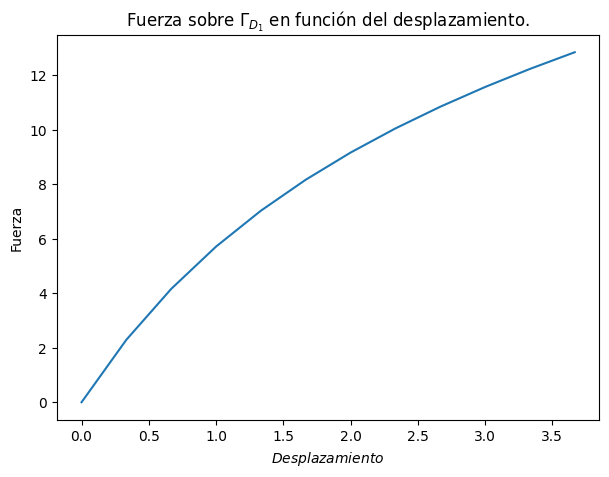

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(alpha*delta_max*np.array(ns)/nmax, forces)
ax.set_ylabel('Fuerza')
ax.set_xlabel(r'$Desplazamiento$')
ax.set_title(r'Fuerza sobre $\Gamma_{D_1}$ en función del desplazamiento.')
plt.show()